In [52]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore",category=FutureWarning)
warnings.filterwarnings("ignore",category=UserWarning)
import ase
import os
from ase.io import read
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import rankdata
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader, Dataset, Data, InMemoryDataset
from torch_geometric.utils import dense_to_sparse, degree, add_self_loops
from torch_geometric.utils import degree

In [53]:
graph_max_radius = 5.0
graph_max_neighbors = 12
LR = 0.001
# LR = 8.28967316828403e-05
eps_rate = 1.7687722582665366e-05
weight_decay = 1.3459636454913954e-06
LOG_INTERVAL = 20
NUM_EPOCHS = 3000

In [54]:
format(float(weight_decay), 'f')

'0.000001'

In [55]:
class GCNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x.float(), data.edge_index#.view(data.edge_index.size(0), -1) 
        # print(x.size())
        # print(data.edge_index.size())
        # print(edge_index.size())
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)

        return x

In [56]:
class AdaptiveGCNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(AdaptiveGCNModel, self).__init__()

        # Initialize a list to hold the GCN layers
        self.gcn_layers = nn.ModuleList()

        # Create GCN layers dynamically based on the input_dim
        for in_dim, out_dim in zip(input_dim, hidden_dim):
            self.gcn_layers.append(GCNConv(in_dim, out_dim))
            input_dim = out_dim  # Update input_dim for the next layer

        # Output layer
        self.output_layer = GCNConv(hidden_dim[-1], output_dim)

    def forward(self, data):
        x, edge_index = data.pos, data.z

        # Apply the dynamically created GCN layers
        for layer in self.gcn_layers:
            x = layer(x, edge_index)
            x = torch.relu(x)

        # Output layer
        x = self.output_layer(x, edge_index)

        return x

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import GINConv, global_add_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp

# SGMNet model
class SGMNet(torch.nn.Module):
    def __init__(self, n_output=1,num_features=114,n_filters=32, embed_dim=128, output_dim=64, dropout=0.3):

        super(SGMNet, self).__init__()

        dim = 32
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.n_output = n_output
        D1_nn1 = Sequential(Linear(num_features, 256), ReLU(), Linear(256, 256))
        self.D1_conv1 = GINConv(D1_nn1)
        self.D1_bn1 = torch.nn.BatchNorm1d(256)

        D1_nn2 = Sequential(Linear(256, 128), ReLU(), Linear(128, 128))
        self.D1_conv2 = GINConv(D1_nn2)
        self.D1_bn2 = torch.nn.BatchNorm1d(128)

        D1_nn3 = Sequential(Linear(128, 32), ReLU(), Linear(32, 32))
        self.D1_conv3 = GINConv(D1_nn3)
        self.D1_bn3 = torch.nn.BatchNorm1d(32)

        # D1_nn4 = Sequential(Linear(64, 32), ReLU(), Linear(32, 32))
        # self.D1_conv4 = GINConv(D1_nn4)
        # self.D1_bn4 = torch.nn.BatchNorm1d(32)

        # combined layers
        self.fc1 = nn.Linear(dim, 16)
        self.fc2 = nn.Linear(16, 8)
        self.out = nn.Linear(8, self.n_output)        # n_output = 1 for regression task

    def forward(self, data):
        x1, edge_index_1, batch1 = data.x.float(), data.edge_index, data.batch
        # print(x1.shape)
        # print(edge_index_1.shape)
        x1 = F.relu(self.D1_conv1(x1, edge_index_1))
        x1 = self.D1_bn1(x1)
        x1 = F.relu(self.D1_conv2(x1, edge_index_1))
        x1 = self.D1_bn2(x1)
        x1 = F.relu(self.D1_conv3(x1, edge_index_1))
        x1 = self.D1_bn3(x1)
        # x1 = F.relu(self.D1_conv4(x1, edge_index_1))
        # x1 = self.D1_bn4(x1)
        x1 = global_add_pool(x1, batch1)
       
        # add some dense layers
        x1 = self.fc1(x1)
        x1 = self.relu(x1)
        x1 = self.dropout(x1)
        x1 = self.fc2(x1)
        x1 = self.relu(x1)
        x1 = self.dropout(x1)
        out = self.out(x1)
        return out

In [58]:
mofs = read('OMDB-GAP1_v1.1/structures.xyz',index=':')
refcodes = np.genfromtxt('OMDB-GAP1_v1.1/CODids.csv',delimiter=',',dtype=str)
properties = np.genfromtxt('OMDB-GAP1_v1.1/bandgaps.csv',delimiter=',',dtype=str)

In [59]:
from sklearn.preprocessing import LabelBinarizer
index = 0
for material in mofs:
    if index == 0:
        length = [len(material)]
        elements = [list(set(material.get_chemical_symbols()))]
    else:
        length.append(len(material))
        elements.append(list(set(material.get_chemical_symbols())))
    index +=1
species = list(set(sum(elements, [])))
species.sort()
lb = LabelBinarizer()
lb.fit(species)

LabelBinarizer()

In [60]:
from sklearn.model_selection import train_test_split

In [61]:
mofs[0]

Atoms(symbols='C30H56Mo2N8O4P4', pbc=True, cell=[[8.487989, 0.0, -0.505023], [-3.031581, 7.876696, -1.51585], [0.0, 0.0, 14.584]])

In [62]:
X_train, X_test, y_train, y_test = train_test_split(mofs, properties, test_size=0.15)

In [63]:
##Obtain node degree in one-hot representation
def OneHotDegree(data, max_degree, in_degree=False, cat=True):
    idx, x = data.edge_index[1 if in_degree else 0], data.x
    deg = degree(idx, data.num_nodes, dtype=torch.long)
    deg = F.one_hot(deg, num_classes=max_degree + 1).to(torch.float)

    if x is not None and cat:
        x = x.view(-1, 1) if x.dim() == 1 else x
        data.x = torch.cat([x, deg.to(x.dtype)], dim=-1)
    else:
        data.x = deg

    return data


def threshold_sort(matrix, threshold, neighbors, reverse=False, adj=False):
    mask = matrix > threshold
    distance_matrix_trimmed = np.ma.array(matrix, mask=mask)
    if reverse == False:
        distance_matrix_trimmed = rankdata(
            distance_matrix_trimmed, method="ordinal", axis=1
        )
    elif reverse == True:
        distance_matrix_trimmed = rankdata(
            distance_matrix_trimmed * -1, method="ordinal", axis=1
        )
    distance_matrix_trimmed = np.nan_to_num(
        np.where(mask, np.nan, distance_matrix_trimmed)
    )
    distance_matrix_trimmed[distance_matrix_trimmed > neighbors + 1] = 0

    if adj == False:
        distance_matrix_trimmed = np.where(
            distance_matrix_trimmed == 0, distance_matrix_trimmed, matrix
        )
        return distance_matrix_trimmed
    elif adj == True:
        adj_list = np.zeros((matrix.shape[0], neighbors + 1))
        adj_attr = np.zeros((matrix.shape[0], neighbors + 1))
        for i in range(0, matrix.shape[0]):
            temp = np.where(distance_matrix_trimmed[i] != 0)[0]
            adj_list[i, :] = np.pad(
                temp,
                pad_width=(0, neighbors + 1 - len(temp)),
                mode="constant",
                constant_values=0,
            )
            adj_attr[i, :] = matrix[i, adj_list[i, :].astype(int)]
        distance_matrix_trimmed = np.where(
            distance_matrix_trimmed == 0, distance_matrix_trimmed, matrix
        )
        return distance_matrix_trimmed, adj_list, adj_attr
    
def get_edge_index(atoms, cutoff=5.0):
    """
    Given an ASE Atoms object, create the edge_index tensor based on a cutoff distance.

    Parameters:
    - atoms (Atoms): ASE Atoms object representing the atomic structure.
    - cutoff (float): Cutoff distance for determining connected atoms.

    Returns:
    - edge_index (torch.Tensor): Tensor representing the graph connectivity.
    """

    positions = torch.tensor(atoms.get_positions(), dtype=torch.float32)
    num_atoms = positions.shape[0]

    # Create a pairwise distance matrix
    distances = np.linalg.norm(positions.numpy()[:, None, :] - positions.numpy()[None, :, :], axis=-1)

    # Find connected atoms based on the cutoff
    connected_atoms = np.argwhere(distances < cutoff)

    # Convert to a torch tensor
    edge_index = torch.tensor(connected_atoms, dtype=torch.long).t().contiguous()

    return edge_index

In [64]:
from typing import Callable, List, Optional


class BandgapDataset(InMemoryDataset):
    def __init__(self, root: str, dataset: str,
                 X: Optional[Callable] = None,y: Optional[Callable] = None,
                #  train: bool = True,
                 transform: Optional[Callable] = None,
                 pre_transform: Optional[Callable] = None,
                 pre_filter: Optional[Callable] = None):
        super().__init__(root, transform, pre_transform, pre_filter)
        # path = self.processed_paths[0] if train else self.processed_paths[1]
        # self.data, self.slices = torch.load(path)
        self.dataset = dataset
        if os.path.isfile(self.processed_paths[0]):
#             print('Pre-processed data found: {}, loading ...'.format(self.processed_paths[0]))
            self.data, self.slices = torch.load(self.processed_paths[0])
        else:
            print('Pre-processed data {} not found, doing pre-processing...'.format(self.processed_paths[0]))
            self.process(X,y)
            self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        pass

    def download(self):
        # Download to `self.raw_dir`.
        pass

    def _download(self):
        pass

    def _process(self):
        if not os.path.exists(self.processed_dir):
            os.makedirs(self.processed_dir)

    @property
    def processed_file_names(self):
        return [self.dataset + '.pt']


    def process(self,X,labels):


        data_list = []
        index = 0
        elements = []
        max_atoms = 0
        for material, bandgap in zip(X, labels):
            data = Data()
            data.ase = material
            distance_matrix = material.get_all_distances(mic=True)
            distance_matrix_trimmed = threshold_sort(
                distance_matrix,
                graph_max_radius,
                12,
                adj=False,
            )
            
            distance_matrix_trimmed = torch.Tensor(distance_matrix_trimmed)
            out = dense_to_sparse(distance_matrix_trimmed)
            # edge_index = out[0]
            ##Obtain distance matrix with ase

            edge_index = out[0]
            edge_weight = out[1]
            edge_index, edge_weight = add_self_loops(
                edge_index, edge_weight, num_nodes=len(material), fill_value=0
            )
            data.edge_index = edge_index
            data.edge_weight = edge_weight

            # edge_index = get_edge_index(material,1.2)
            # data.edge_index = edge_index
            # edge_index = torch.tensor(material.get_all_distances()).nonzero().t().contiguous()
            # data.edge_index = edge_index
            # x = torch.from_numpy(material.get_positions()).to(torch.float)
            # data.x = x
            y = torch.tensor([float(bandgap)])
            data.y =y
            z = torch.LongTensor(material.get_atomic_numbers())
            data.z = z

            ###placeholder for state feature
            u = np.zeros((3))
            u = torch.Tensor(u[np.newaxis, ...])
            data.u = u
            data_list.append(data)
            index += 1

        
        # species = list(set(sum(elements, [])))
        # species.sort()
        # lb = LabelBinarizer()
        # lb.fit(species)
        for index in range(0, len(data_list)):
            data_list[index].x = torch.Tensor(
                lb.transform(data_list[index].ase.get_chemical_symbols())
            )

        for index in range(0, len(data_list)):
            data_list[index] = OneHotDegree(
                data_list[index], 13
            )

        if self.pre_filter is not None:
            data_list = [d for d in data_list if self.pre_filter(d)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(d) for d in data_list]

        torch.save(self.collate(data_list), self.processed_paths[0])


In [65]:
# Instantiate datasets and dataloaders
train_dataset = BandgapDataset('./OMDB-GAP1_v1.1','train_dataset',X_train, y_train)
test_dataset = BandgapDataset('./OMDB-GAP1_v1.1','test_dataset',X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [66]:
train_dataset[0].ase.get_all_distances().shape

(62, 62)

In [67]:
train_dataset[0].edge_weight.shape

torch.Size([806])

In [68]:
if torch.cuda.is_available():  
    device = "cuda:0"
    print("cuda:0")
else:  
    device = "cpu" 
    print(torch.cuda.is_available())

cuda:0


In [69]:
from torchviz import make_dot

In [ ]:
model = SGMNet(num_features=79).to(device)
print(model)


SMGNet(
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
  (D1_conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=79, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  ))
  (D1_bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (D1_conv2): GINConv(nn=Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  ))
  (D1_bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (D1_conv3): GINConv(nn=Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
  ))
  (D1_bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=32, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias

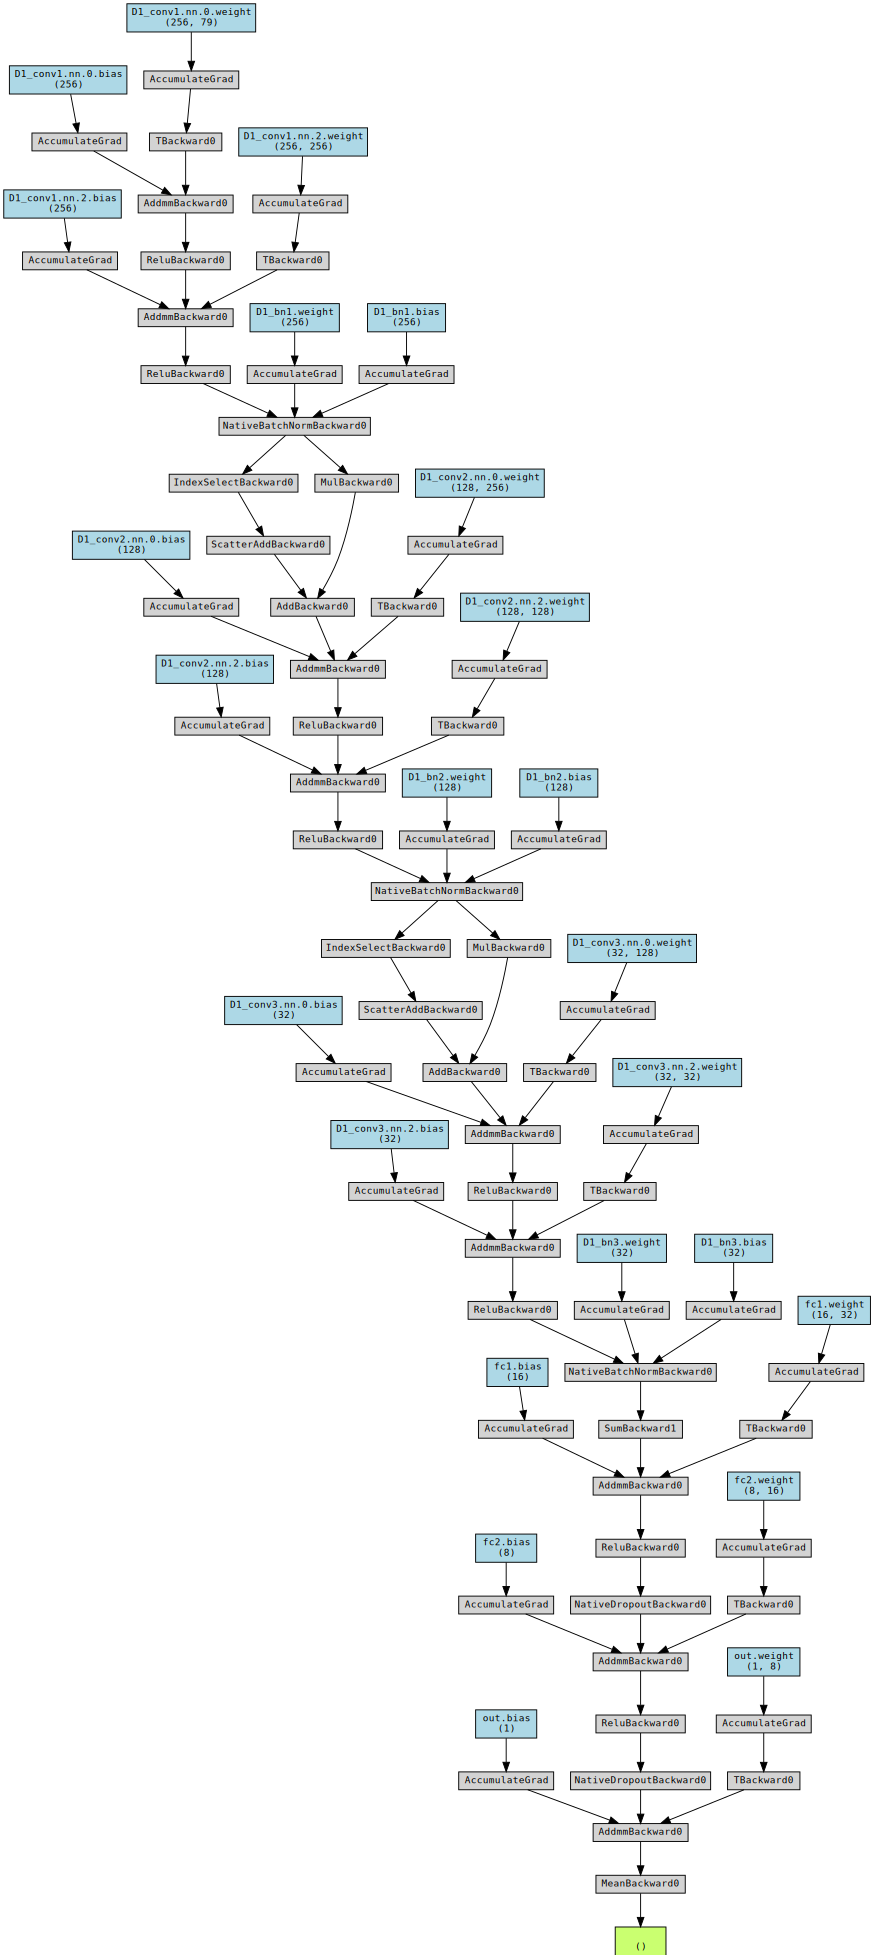

In [71]:
x = next(iter(train_loader))[0].to(device)
y = model(x)
make_dot(y.mean(), params=dict(model.named_parameters()))

In [72]:
# training function at each epoch
def train(model, device, train_loader, optimizer, epoch,loss_fn):
    #print('Training on {} samples...'.format(len(train_loader1.dataset)))
    model.train()
    Loss = []
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, data.y.view(-1, 1).float().to(device))
        loss.backward()
        optimizer.step()
        Loss.append(loss.item())
    nploss = np.asarray(Loss)
    avg_loss = np.average(nploss)
    return avg_loss


def validation(model, device, loader,loss_fn):
    model.eval()
    total_loss=total_example=0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            output = model(data)
            loss = loss_fn(output, data.y.view(-1, 1).float().to(device))
            total_loss+=loss
            total_example+=1
    return total_loss/total_example

In [73]:
loss_fn = nn.L1Loss()
# loss_fn = nn.MSELoss()
model = model.cuda(device)
optimizer = torch.optim.Adam(model.parameters(),lr=LR,betas=(0.9,0.999),
                                 eps=eps_rate,weight_decay=weight_decay,amsgrad=False)

In [ ]:
best_ret = []
best_mse = 0.80
best_ci = 0
best_epoch = -1
model_st = "SGMNet"
model_file_name = 'SGMNet' + model_st  +  '.model'
result_file_name = 'result_' + model_st +  '.csv'

val_losses = []
train_losses = []

the_last_loss = 100
patience = 30
trigger_times = 0
count_loss_difference = 0

for epoch in range(NUM_EPOCHS):
    train_loss=train(model, device, train_loader, optimizer, epoch+1,loss_fn)
    test_loss = validation(model, device, test_loader,loss_fn)
#     test_loss = predicting(model, device, test_loder,loss_fn)
#     print('Epoch% d: Train mae: %2.5f\t val mae: %2.5f\t test mae: %2.5f\t'
#           %(epoch, train_loss, val_loss.item(),test_loss.item()))

    print('Epoch% d: Train mae: %2.5f\t val mae: %2.5f\t'
          %(epoch, train_loss,test_loss.item()))
    ret = [epoch,train_loss,test_loss.item()]
    
    train_losses.append(train_loss)
    val_losses.append(test_loss.item())
    # Early stopping
    the_current_loss = test_loss.item()
    
    if the_current_loss > the_last_loss:
        trigger_times += 1
        print('trigger times:', trigger_times)

        if trigger_times >= patience:
            print('Early stopping!\nStart to test process.')
            break
    else:
        
        trigger_times = 0
        the_last_loss = the_current_loss
        torch.save(model.state_dict(), 'SGMNet.model')


    with open(result_file_name,'w') as f:
        f.write(','.join(map(str,ret)))

Epoch 0: Train mae: 1.78371	 val mae: 1.23048	
Epoch 1: Train mae: 1.36721	 val mae: 1.27417	
trigger times: 1
Epoch 2: Train mae: 1.25324	 val mae: 0.95351	
Epoch 3: Train mae: 1.23503	 val mae: 0.98069	
trigger times: 1
Epoch 4: Train mae: 1.14482	 val mae: 0.91190	
Epoch 5: Train mae: 1.09970	 val mae: 0.83603	
Epoch 6: Train mae: 1.06466	 val mae: 0.97681	
trigger times: 1
Epoch 7: Train mae: 1.01997	 val mae: 0.80707	
Epoch 8: Train mae: 0.98582	 val mae: 0.85060	
trigger times: 1
Epoch 9: Train mae: 0.94356	 val mae: 0.80893	
trigger times: 2
Epoch 10: Train mae: 0.92853	 val mae: 0.86163	
trigger times: 3
Epoch 11: Train mae: 0.94588	 val mae: 0.84980	
trigger times: 4
Epoch 12: Train mae: 0.87306	 val mae: 0.81783	
trigger times: 5
Epoch 13: Train mae: 0.85691	 val mae: 0.75824	
Epoch 14: Train mae: 0.83580	 val mae: 0.74271	
Epoch 15: Train mae: 0.80119	 val mae: 0.76931	
trigger times: 1
Epoch 16: Train mae: 0.78447	 val mae: 0.68548	
Epoch 17: Train mae: 0.78271	 val mae: 0.

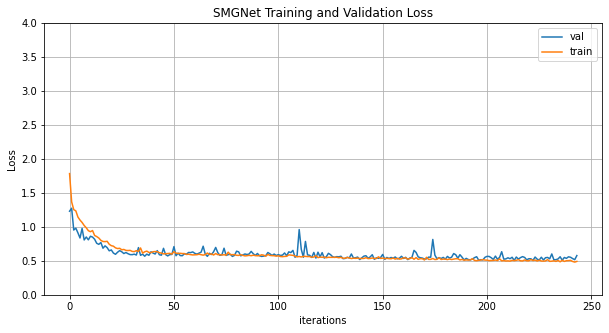

In [ ]:
plt.figure(figsize=(10,5))
plt.title("SGMNet Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.ylim(0, 4)
plt.grid(True)
plt.savefig('SGMNetTrainAndValidation.png', dpi=400,transparent=True)
plt.show()

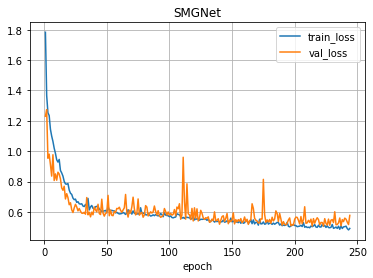

In [ ]:
ax = plt.subplot(1,1,1)
ax.plot([e for e in range(1,len(train_losses) + 1)], train_losses, label="train_loss")
ax.plot([e for e in range(1,len(val_losses) + 1)], val_losses, label="val_loss")
plt.xlabel("epoch")
plt.title('SGMNet')
plt.grid(True)
plt.savefig('SGMNetTrain.png', dpi=400,transparent=True)
ax.legend()

In [ ]:
model.load_state_dict(torch.load('SGMNet.model'))
model.eval()

SMGNet(
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
  (D1_conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=79, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  ))
  (D1_bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (D1_conv2): GINConv(nn=Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  ))
  (D1_bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (D1_conv3): GINConv(nn=Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
  ))
  (D1_bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=32, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias

In [78]:
y_pred_arr = []
target_array = []
for data in test_loader:
    data = data.to(device)
    y_pred = model(data)
    #y_pred = model(data.x.float(), data.edge_index,data.batch)
    y_pred_arr.append(y_pred)
    target_array.append(data.y.float())

In [79]:
y_ped=torch.cat(y_pred_arr).view(-1).cpu().detach().numpy()
y_true=torch.cat(target_array).cpu().detach().numpy()

In [80]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
regression_results(y_true,y_ped)

explained_variance:  0.5863
mean_squared_log_error:  0.0391
r2:  0.5739
MAE:  0.5065
MSE:  0.4557
RMSE:  0.6751


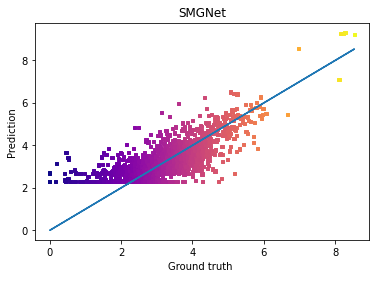

In [ ]:
# plt.scatter(y_ped,y_true,s=10,marker ="s",c=y_true,cmap=plt.get_cmap('plasma'))
plt.scatter(y_true,y_ped,s=10,marker ="s",c=y_true,cmap=plt.get_cmap('plasma'))
plt.plot(y_true,y_true)
plt.xlabel('Ground truth \n')
plt.ylabel('Prediction')
plt.title('SGMet')
plt.grid(False)
plt.savefig('SGMNet.png', dpi=400,transparent=True,bbox_inches = "tight")
plt.show()

In [82]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
import math

In [83]:
MSE = mean_squared_error(y_true, y_ped)
print(MSE)
print(mean_absolute_error(y_true,y_ped))


0.4556981
0.5064731


In [84]:
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

Root Mean Square Error:

0.6750541479856496


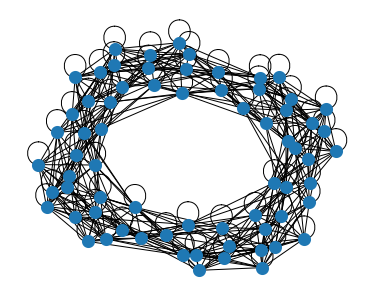

In [85]:
import networkx as nx
from torch_geometric import torch_geometric
data = train_dataset[100]
gdata = torch_geometric.data.Data(x=data.x.float(), edge_index=data.edge_index)
g = torch_geometric.utils.to_networkx(gdata, to_undirected=True)
plt.figure(1,figsize=(5,4)) 
nx.draw(g, cmap=plt.get_cmap('Set1'),node_size=50,linewidths=6)


In [86]:
## Sklearn Package Loading
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, RandomizedSearchCV,KFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, mean_squared_error,r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor,RandomForestRegressor
from xgboost import XGBRegressor

In [87]:
df = pd.read_csv("final_db.csv", sep='\t')
df= df.dropna(axis = 0, how ='any')  
df.reset_index(drop=True)


,Unnamed: 0,ids,bandgaps,_chemical_formula_sum,_chemical_formula_weight,_space_group_IT_number,_symmetry_cell_setting,_symmetry_space_group_name_H-M,_cell_angle_alpha,_cell_angle_beta,...,_diffrn_reflns_limit_k_min,_diffrn_reflns_limit_l_max,_diffrn_reflns_limit_l_min,_diffrn_reflns_number,_diffrn_reflns_theta_full,_diffrn_reflns_theta_max,_diffrn_reflns_theta_min,_exptl_absorpt_coefficient_mu,_exptl_absorpt_correction_T_max,_exptl_absorpt_correction_T_min
0,0,4074437,1.118755,C15 H28 Mo N4 O2 P2,454.29,2.0,3.0,P -1,100.1820,93.4050,...,-11.0,18.0,-19.0,4267.0,-100.000,27.940,3.940,0.852,0.7849,0.7015
1,1,7226496,3.335133,C11 H8 Cl4 O3,329.97,2.0,-100.1,P -1,84.5490,86.3220,...,-8.0,19.0,-14.0,4489.0,25.214,26.015,2.618,0.770,0.9650,0.9200
2,2,1507720,2.854547,C19 H17 N O5,339.34,2.0,3.0,P -1,82.1660,78.0000,...,-11.0,14.0,0.0,8848.0,27.450,27.450,1.830,0.108,0.9957,0.9633
3,3,7215594,3.145922,C11 H10 Cl2 N2,241.11,9.0,1.0,C 1 c 1,90.0000,100.0240,...,-21.0,16.0,-16.0,3681.0,25.000,25.000,4.500,0.568,1.0000,0.7330
4,4,2101963,3.467795,C12 H13 N O2,203.24,14.0,1.0,P 1 21/c 1,90.0000,110.8900,...,0.0,7.0,-7.0,2917.0,-100.100,25.000,2.000,0.090,-100.1000,-100.1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12392,12494,7103466,2.515412,C11 H21 O2 P,216.25,2.0,3.0,P -1,79.0472,85.1087,...,-12.0,17.0,-17.0,26437.0,30.720,30.720,1.740,0.200,-100.1000,-100.1000
12393,12495,4029970,1.896349,C21 H24 O2,308.40,2.0,-100.1,P -1,100.4130,92.5030,...,-8.0,20.0,-2.0,2211.0,66.650,66.650,2.540,0.613,-100.1000,-100.1000
12394,12496,7104280,3.867184,C40 H48 N4 P2,646.76,2.0,3.0,P -1,85.8725,74.5382,...,-12.0,13.0,-13.0,9748.0,26.370,26.370,2.560,0.158,0.9920,0.9620
12395,12497,4501868,4.307790,C22 H46 N6 S2,458.77,2.0,3.0,P -1,85.8910,76.8830,...,-12.0,12.0,-12.0,7305.0,26.990,26.990,2.180,0.226,0.9821,0.9394


In [88]:
X = df.drop(['Unnamed: 0','ids', '_chemical_formula_sum', '_symmetry_space_group_name_H-M','bandgaps'], axis=1)
Y = df['bandgaps']
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, Y, test_size=0.15, random_state=20)

In [89]:
# Normalize train and test set
sc = StandardScaler()
X_train1 = sc.fit_transform(X_train1)
X_test1 = sc.transform(X_test1)

In [90]:
linear = LinearRegression()
linear.fit(X_train1,y_train1)

y_pred_linear = linear.predict(X_test1)

In [91]:
rfc = RandomForestRegressor(n_jobs=2,random_state=0)
lab_enc = preprocessing.LabelEncoder()
rfc.fit(X_train1,y_train1)

y_pred_rf = rfc.predict(X_test1)

linear.fit(y_test1.values.reshape(-1, 1),y_pred_rf.reshape(-1, 1))
call = y_test1.values.reshape(-1,1)
line = linear.predict(call)

In [92]:
svr = SVR(C=100)
svr.fit(X_train1,y_train1)

y_pred_svr = svr.predict(X_test1)

In [93]:
dt = DecisionTreeRegressor()
dt.fit(X_train1,y_train1)

y_pred_dt = dt.predict(X_test1)

In [ ]:
#Root Mean squared error
linear_mse = math.sqrt(mean_squared_error(y_pred_linear,y_test1))
rf_mse = math.sqrt(mean_squared_error(y_pred_rf,y_test1))
svr_mse = math.sqrt(mean_squared_error(y_pred_svr,y_test1))
dt_mse = math.sqrt(mean_squared_error(y_pred_dt,y_test1))

mse = [linear_mse, rf_mse, svr_mse,dt_mse,math.sqrt(MSE)]
models = ['LR', 'RF', 'SVR','DT','SGMNet']
y_pos = np.arange(len(models))
y_pos

array([0, 1, 2, 3, 4])

Text(0, 0.5, 'Root Mean squared error')

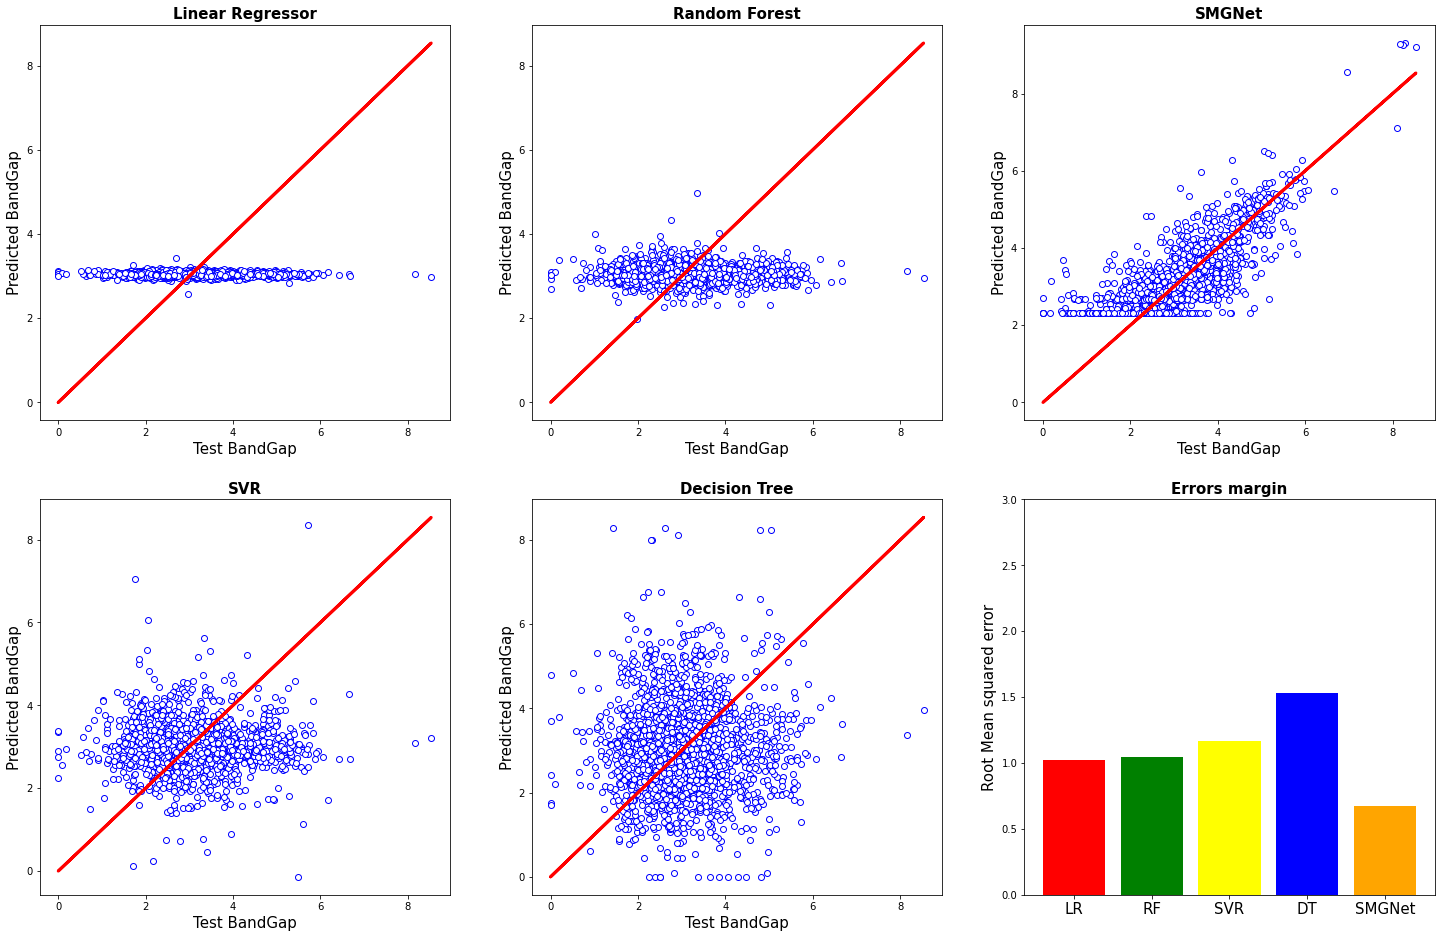

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(25,16))
axs[0, 0].scatter(y_test1, y_pred_linear , marker ='o', edgecolor ='blue',color='white')
axs[0, 0].plot(y_test1, y_test1, color='red',linewidth=3)
axs[0, 0].set_title("Linear Regressor",fontweight="bold",size=15)
axs[0, 0].set_xlabel('Test BandGap',size=15)
axs[0, 0].set_ylabel('Predicted BandGap',size=15)

axs[0, 1].scatter(y_test1, y_pred_rf , marker ='o', edgecolor ='blue',color='white')
axs[0, 1].plot(y_test1, y_test1, color='red',linewidth=3)
axs[0, 1].set_title("Random Forest",fontweight="bold",size=15)
axs[0, 1].set_xlabel('Test BandGap',size=15)
axs[0, 1].set_ylabel('Predicted BandGap',size=15)

axs[1, 0].scatter(y_test1, y_pred_svr , marker ='o', edgecolor ='blue',color='white')
axs[1, 0].plot(y_test1, y_test1, color='red',linewidth=3)
axs[1, 0].set_title("SVR",fontweight="bold",size=15)
axs[1, 0].set_xlabel('Test BandGap',size=15)
axs[1, 0].set_ylabel('Predicted BandGap',size=15)

axs[1, 1].scatter(y_test1, y_pred_dt , marker ='o', edgecolor ='blue',color='white')
axs[1, 1].plot(y_test1, y_test1, color='red',linewidth=3)
axs[1, 1].set_title("Decision Tree",fontweight="bold",size=15)
axs[1, 1].set_xlabel('Test BandGap',size=15)
axs[1, 1].set_ylabel('Predicted BandGap',size=15)

axs[0, 2].scatter(y_true,y_ped, marker ='o', edgecolor ='blue',color='white')
axs[0, 2].plot(y_true, y_true, color='red',linewidth=3)
axs[0, 2].set_title("SGMNet",fontweight="bold",size=15)
axs[0, 2].set_xlabel('Test BandGap',size=15)
axs[0, 2].set_ylabel('Predicted BandGap',size=15)

axs[1, 2].bar(y_pos, mse, color=['red','green','yellow','blue','orange'])
axs[1, 2].set_ylim([0,3.0])
axs[1, 2].set_xticks(y_pos)
axs[1, 2].set_xticklabels(models)
axs[1, 2].tick_params(axis='x', labelsize=15)
axs[1, 2].set_title("Errors margin",fontweight="bold",size=15)
axs[1, 2].set_ylabel('Root Mean squared error',size=15)

